In order to run the code in parallel, we first need to add some julia processes.

In [ ]:
using Distributed
addprocs(7)
nprocs()

# Shared memory parallelization of block banded matrices

The objective is to parallelize block banded matrices using a shared memory
model. Block banded matrices can be parameterized to accept different kinds of
storage back-ends. Among other things, it means block banded matrices can be
parallelized simply by telling them to use a `SharedArray` as storage:

In [ ]:
@everywhere begin
    using Pkg
    Pkg.activate(pwd())
    using BlockBandedMatrices: BandedBlockBandedMatrix, _BandedBlockBandedMatrix
    using BlockBandedMatrices: BandedBlockBandedSizes
    using BlockArrays: PseudoBlockArray, Block, nblocks
    using SharedArrays: SharedArray

    const SharedPseudoBlock = 
        PseudoBlockArray{T, 2, SharedArray{T, 2}, B} where {T, B}
    const SharedBandedBlockBandedMatrix =
        BandedBlockBandedMatrix{T, SharedPseudoBlock{T, B}} where {T, B}
end

Well, it's almost that simple. The point is that block banded matrices are
composed of blocks. So the storage type must be aware both of how to handle
blocks and how to share them across processes. Hence, the `SharedPseudoBlock`
type above. It creates a pseudo block array - where blocks are stored in a
single container - backed by a shared array.

We can now create an overloaded function to initialize the array:

In [3]:
@everywhere function SharedBandedBlockBandedMatrix{T}(
        ::UndefInitializer, bs::BandedBlockBandedSizes; kwargs...) where T
    shared = SharedArray{T}(size(bs); kwargs...)
    block = PseudoBlockArray(shared, bs.data_block_sizes)
    _BandedBlockBandedMatrix(block, bs)
end

@everywhere function SharedBandedBlockBandedMatrix{T}(
        ::UndefInitializer,
        dims::NTuple{2, AbstractVector{Int}},
        lu::NTuple{2, Int},
        λμ::NTuple{2, Int};
        kwargs...
) where T
    blocksizes = BandedBlockBandedSizes(dims..., lu..., λμ...)
    SharedBandedBlockBandedMatrix{T}(undef, blocksizes; kwargs...)
end

To illustrate this, let's create a banded block banded matrix with blocks
composed of 10x10 matrices (`n` and `m`), with the band of blocks from `l` to
`u` and each block banded from `λ` to `μ`.

In [ ]:
N, n = 2, 3
l, u, λ, μ = 1, 0, 0, 2
M, m = N + 1, n + 1
A = SharedBandedBlockBandedMatrix{Float64}(undef, (repeat([n], N), repeat([m], M)), (l, u), (λ, μ))

But what we really want to do is to populate the matrix in parallel. We can do
this by allocating blocks for each process to write to:

In [ ]:
@everywhere function populate!(
        A::SharedBandedBlockBandedMatrix, block_populate!::Function)
    @sync begin
        for (p, proc) in enumerate(procs(A.data.blocks))
            @async remotecall_wait(populate!, proc, A, p, block_populate!)
        end
    end
    A
end

@everywhere function nmutableblocks(A::SharedBandedBlockBandedMatrix)
    n = nblocks(A, 1)
    for i in 1:nblocks(A, 1)
        n += min(i + A.u, nblocks(A, 2)) - max(i - A.l, 1)
    end
    n
end

@everywhere function populate!(
        A::SharedBandedBlockBandedMatrix, p, block_populate!::Function)
    n = nmutableblocks(A)

    m = length(procs(A.data.blocks))
    start = (n ÷ m) * (p - 1) + min((n % m), p - 1)
    stop = (n ÷ m) * p + min((n % m), p)

    k = 0
    for i in 1:nblocks(A, 1), j in max(i - A.l, 1):min(i + A.u, nblocks(A, 2))
        if k >= stop
            break
        elseif k >= start
            block_populate!(view(A, Block(i, j)), i, j)
        end
        k += 1
    end
    A
end

@everywhere populate!(bpop!::Function, args...) = populate!(args..., bpop!)

Above, we first create a list with all the non-zero blocks in the matrix. We
split it into contiguous chunks, one chunk per process, and then we order each
process to populate those chunks only. Strictly speaking, this is more
information then actually needs to be sent to each process. We could instead
shift the work of computing the list of blocks to the processes and send only
the range each process should could compute, i.e. send only two integers.
However, we will soon find that, although this algorithm's performance is
limited by process IO consideration (rather the compute bound), bandwidth is not
the issue.  And this implementation is simpler.

The magic happens in the `@sync` code-block. In practice, each `@async`
generates a task and schedules it to be sent and executed by a process.
Generating and scheduling a task takes very little time, compared to actually
executing them (More specifically, when that statement is not true, then it's
better to stick to running tasks serially). Then, right before exiting the
`@sync` code-block, the tasks are sent over to the processes, and the code waits
until the tasks are finished running.

In practice, usage looks like this:

In [ ]:
populate!(A) do block, i, j
    for x in 1:size(block, 1), y in max(x - A.λ, 1):min(x + A.μ, size(block, 2))
        block[x, y] = 1
    end
end

For comparison we also construct the serial version of populate, as well as a
simple scheme to fill blocks with ones:

In [7]:
@everywhere function populate!(
        A::BandedBlockBandedMatrix, block_populate!::Function)
    for i in 1:nblocks(A, 1), j in max(i - A.l, 1):min(i + A.u, nblocks(A, 2))
        block_populate!(view(A, Block(i, j)), i, j)
    end
    A
end

@everywhere function simplefill!(A::BandedBlockBandedMatrix)
    populate!(A) do bk, i, j
        for x in 1:size(bk, 1), y in max(x - A.λ, 1):min(x + A.μ, size(bk, 2))
            bk[x, y] = 1
        end
    end
end

And now we can run benchmarks:

In [ ]:
using BenchmarkTools

N, n = 8, 3
l, u, λ, μ = 1, 2, 0, 1
M, m = 6, n
A = SharedBandedBlockBandedMatrix{Float64}(undef, (repeat([n], N), repeat([m], M)), (l, u), (λ, μ))
nmutableblocks(A)
@benchmark simplefill!($A)

In [9]:
B = BandedBlockBandedMatrix{Float64}(undef, (repeat([n], N), repeat([m], M)), (l, u), (λ, μ))
@benchmark simplefill!($B)

BenchmarkTools.Trial: 
  memory estimate:  3.30 KiB
  allocs estimate:  43
  --------------
  minimum time:     1.155 μs (0.00% GC)
  median time:      1.198 μs (0.00% GC)
  mean time:        1.983 μs (37.15% GC)
  maximum time:     4.696 ms (99.95% GC)
  --------------
  samples:          10000
  evals/sample:     10

And that's not a win for the multi-core team... But we do not always expect a
win in every situation. Surely, the performance depends on the size of the
matrix? So let's try a few:

In [12]:
n, l, u, λ, μ = 500, 1, 2, 2, 1
serial, parallel, Ns = [], [], [10, 50, 100, 150, 200, 300, 500]
for N = Ns
    A = SharedBandedBlockBandedMatrix{Float64}(
            undef, (repeat([n], N), repeat([n], N)), (l, u), (λ, μ))
    bench = @benchmark simplefill!($A)
    push!(parallel, bench)

    B = BandedBlockBandedMatrix{Float64}(
            undef, (repeat([n], N), repeat([n], N)), (l, u), (λ, μ))
    bench = @benchmark simplefill!($B)
    push!(serial, bench)
end

WARN Missing type for channel "color", using "nominal" instead.
WARN Missing type for channel "color", using "nominal" instead.
WARN Missing type for channel "color", using "nominal" instead.
WARN Missing type for channel "color", using "nominal" instead.


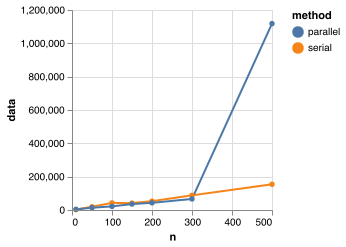

In [13]:
using VegaLite, DataFrames, Statistics
DataFrame(
    data = vcat(
        getfield.(mean.(serial), :time) ./ 1000,
        getfield.(mean.(parallel), :time) ./ 1000,
    ),
    n = repeat(Ns, 2),
    method=vcat(
        repeat([:serial], length(Ns)),
        repeat([:parallel], length(Ns))
    )
) |> @vlplot(mark={:line, point=:true}, x=:n, y=:data, color=:method)

In [ ]:
|